# Poznámky z prezentácie

V tomto dokumente sú replikované algoritmy použíté v SIAP podľa prezentácie a sú z nich vyvedené závery.

In [55]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def xy_plot(x, f):
    return x, np.array([f(xi) for xi in x])

### Výrobná kapacita

  - Fixné náklady ⇒ 48 500€ × etapa produkcie

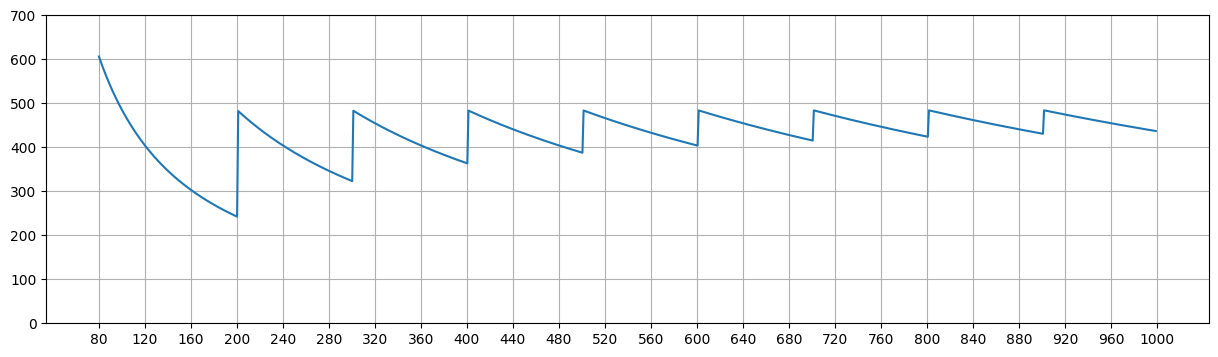

In [52]:
def fixed_cost(production_capacity):
    return 48500 * max(math.floor((production_capacity-1) / 100), 1)


def unit_fixed_cost(production_capacity):
    return fixed_cost(production_capacity) / production_capacity

plt.figure(figsize=(15, 4))
plt.ylim(0, 700)
plt.grid(True)
plt.xticks(np.arange(start=80, stop=1001, step=40))
plt.plot(*xy_plot(np.linspace(start=80, stop=999,num=999-80), unit_fixed_cost))
plt.show()

 - Jednotková cena: $250 + \text{náklady z výskumu}$
 - Produkčná kapacita

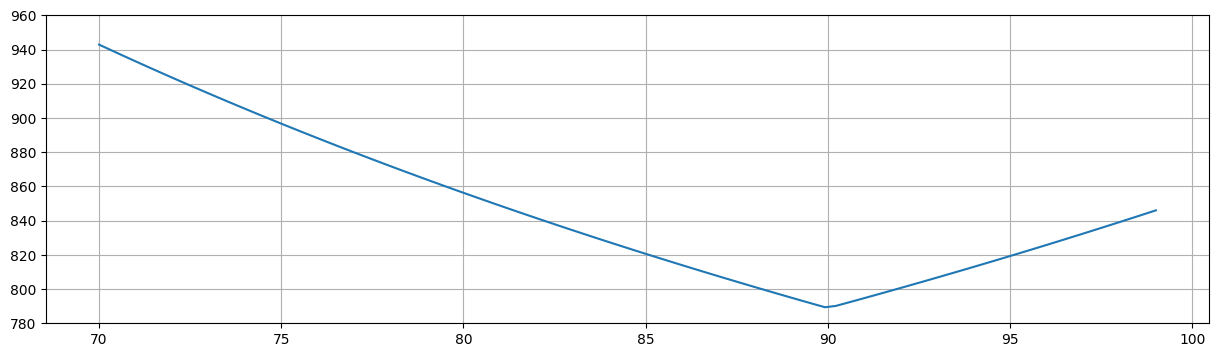

In [51]:
def variable_unit_cost(production_capacity, production, unit_variable_cost=250):
    production_utilization = production / production_capacity
    excessive_production_coef = 1
    if production_utilization > 0.9:
        excessive_production_coef = 1.015 ** (production_utilization*100 - 90)

    raw_production_cost = production * unit_variable_cost + fixed_cost(production_capacity)
    production_cost = raw_production_cost * excessive_production_coef
    unit_production_cost = production_cost / production
    return unit_production_cost


plt.figure(figsize=(15, 4))
plt.ylim(780, 960)
plt.xticks(np.arange(start=70, stop=101, step=5))
plt.grid(True)
plt.plot(*xy_plot(np.linspace(start=70, stop=99, num=100), lambda x:variable_unit_cost(production_capacity=100, production=x)))
plt.show()

### Kapitál

  - Odpisovanie ⇒ $5\%$ za rok — čiže $1.25\%$ za kvartál (jedno kolo)
  - Produkčná kapacita ⇒ $kapitál / 500$

In [53]:
def production_capacity(capital):
    return math.floor(capital / 500)

### R&D

In [71]:
improvements = pd.DataFrame(
    [
        {"name": "Brzdy", "cost": 18000, "variable_increase": 0.1, "modifier": 0.45},
        {"name": "Rám", "cost": 22000, "variable_increase": 0.2, "modifier": 0.55},
        {"name": "Batéria", "cost": 30000, "variable_increase": 0.3, "modifier": 0.75},
        {"name": "Display", "cost": 34000, "variable_increase": 0.4, "modifier": 0.85},
    ]
)

improvements.set_index("name", inplace=True)
improvements["modifier_per_cost"] = improvements["modifier"] / improvements["cost"]
improvements["modifier_per_increase"] = improvements["modifier"] / improvements["variable_increase"]

improvements

,cost,variable_increase,modifier,modifier_per_cost,modifier_per_increase
name,,,,,
Brzdy,18000,0.1,0.45,0.000025,4.500
Rám,22000,0.2,0.55,0.000025,2.750
Batéria,30000,0.3,0.75,0.000025,2.500
Display,34000,0.4,0.85,0.000025,2.125


  - Modifkátor vylepšenia je priamo úverný cene
  - Brzdy majú najlepší pomer modifikátoru k zvýšeniu variabilných nákladov

Podľa tohto kritéria je teda optimálnym poradím R&D:

In [73]:
improvements.index[np.argsort(-improvements["modifier_per_increase"])]

Index(['Brzdy', 'Rám', 'Batéria', 'Display'], dtype='object', name='name')

### Marketing

In [70]:
marketing = pd.DataFrame([
    {"name": "OOH", "minimum": 500, "modifier": 1.5},
    {"name": "Virálny", "minimum": 100, "modifier": 1.25, "bonus_per_1k": 0.1},
    {"name": "Billboardy", "minimum": 500, "modifier": 1.0},
    {"name": "Televízia", "minimum": 2000, "modifier": 1.0},
    {"name": "Podcasty", "minimum": 1000, "modifier": 1.25},
])

marketing.set_index("name", inplace=True)
marketing.fillna(0, inplace=True)

marketing

,minimum,modifier,bonus_per_1k
name,,,
OOH,500,1.50,0.0
Virálny,100,1.25,0.1
Billboardy,500,1.00,0.0
Televízia,2000,1.00,0.0
Podcasty,1000,1.25,0.0


<Axes: xlabel='investment'>

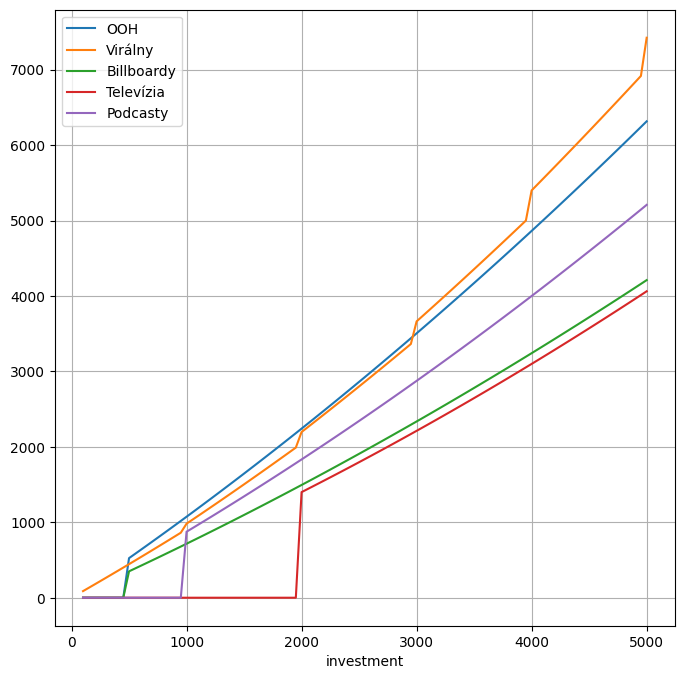

In [100]:
def marketing_effectivity(investment, minimum_investment):
    if investment < minimum_investment:
        return 0
    return 0.7 + 0.3 * (investment - minimum_investment) / (10000 - minimum_investment)

def marketing_yield(investment, type):
    effectivity = marketing_effectivity(investment, type["minimum"])
    modifier = type["modifier"]
    modifier += type["bonus_per_1k"] * math.floor(investment / 1000)
    return investment * effectivity * modifier

yields = pd.DataFrame({ "investment": np.concat([np.arange(start=100, stop=5001, step=50)]) })
for name, type in marketing.iterrows():
    yields[name] = np.array([marketing_yield(xi, type) for xi in yields["investment"]])

yields.set_index("investment", inplace=True)
yields.plot(figsize=(8,8), grid=True)

  - Najlepšia stratégia je Virálny marketing až do 500€, potom OOH až do 3000€, potom znovu Virálny marketing

<Axes: xlabel='investment'>

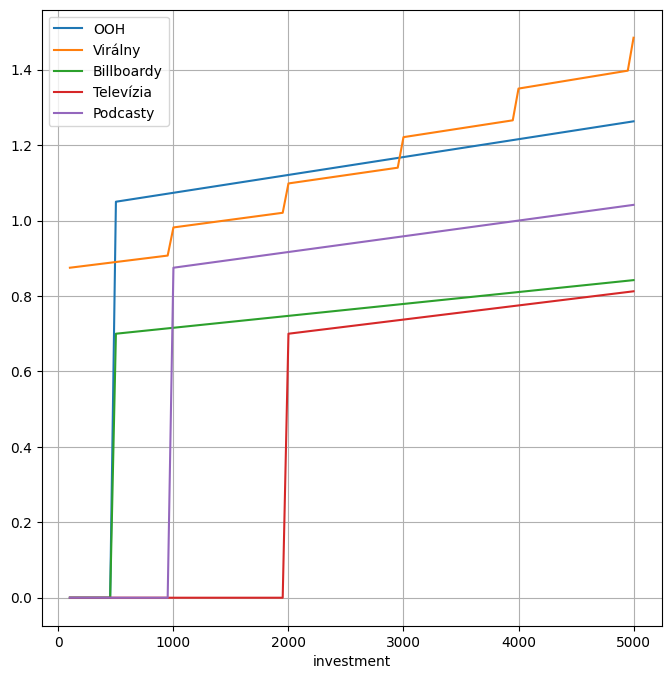

In [102]:
unit_yield = yields.copy()
for investment, row in unit_yield.iterrows():
    unit_yield.loc[investment] = row / investment

unit_yield.plot(figsize=(8,8), grid=True)

 - Neexistuje optimálna investícia do marketingu — Vždy je efektívnejšie investovať viacej

In [105]:
%store marketing
%store improvements

Stored 'marketing' (DataFrame)
Stored 'improvements' (DataFrame)
